In [74]:
import numpy as np
import spacy
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import os
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
import distance
from sklearn.manifold import TSNE
from os import path
import sys
#from wordcloud import WordCloud, STOPWORDS

In [9]:
df=pd.read_csv("QuoraQuestionPairs_train.csv")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<AxesSubplot:xlabel='is_duplicate'>

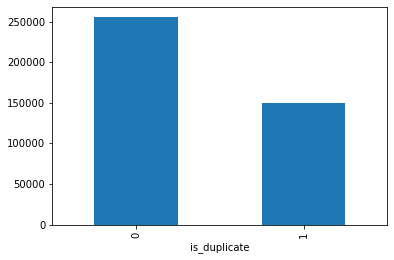

In [12]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [13]:
print("Question pairs are not similar(is_duplicate=0):\n{}%".format(round(100-df['is_duplicate'].mean()*100,2)))
print("Question pairs are  similar(is_duplicate=1):\n{}%".format(round(df['is_duplicate'].mean()*100,2)))

Question pairs are not similar(is_duplicate=0):
63.08%
Question pairs are  similar(is_duplicate=1):
36.92%


In [14]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_ques=len(np.unique(qids))
print("Total number of Unique Questions: {}".format(unique_ques))
ques_morethan_onetime = np.sum(qids.value_counts()>1)
print("Total number of Unique Questions that appear more than one time: {} ({}%)".format(ques_morethan_onetime,ques_morethan_onetime/unique_ques*100)) 
print("Max number of times a single question is repeated: {}".format(max(qids.value_counts())))

Total number of Unique Questions: 537933
Total number of Unique Questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


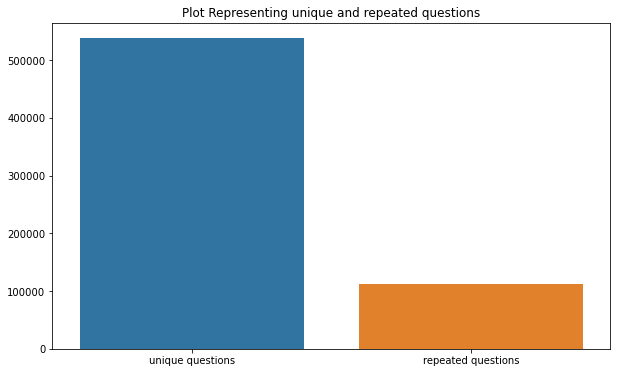

In [15]:
x=["unique questions","repeated questions"]
y=[unique_ques,ques_morethan_onetime]
plt.figure(figsize=(10,6))
plt.title("Plot Representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

In [16]:
#Checking Number of duplicate Pairs
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Total number of Duplicate Pairs: {}".format(pair_duplicates.shape[0]-df.shape[0]))

Total number of Duplicate Pairs: 0


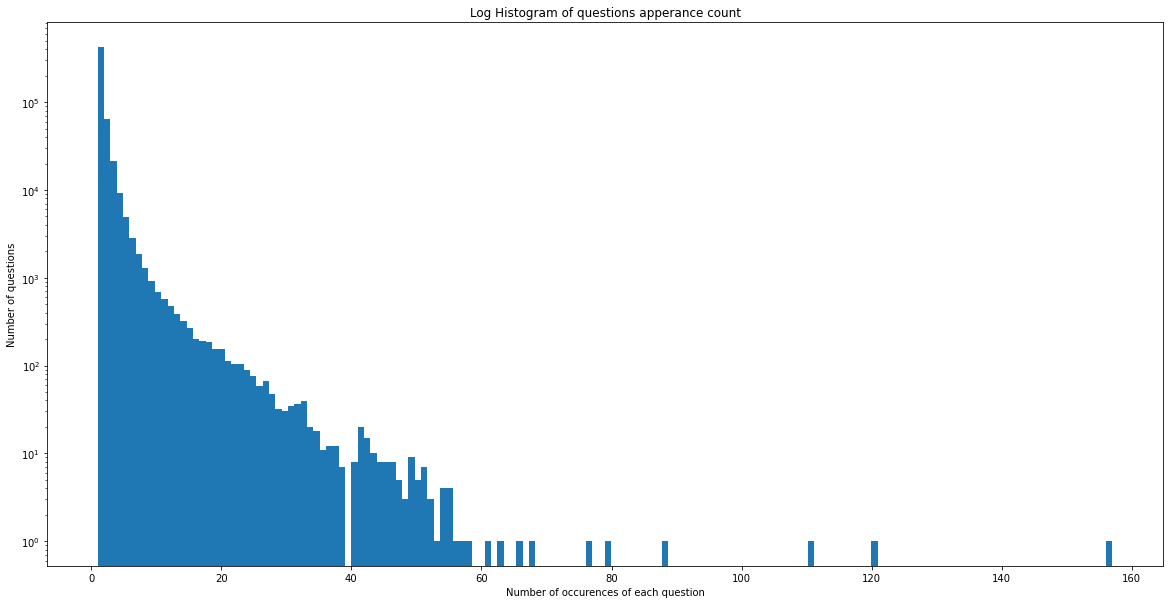

In [17]:
plt.figure(figsize=(20,10))
plt.title("Log Histogram of questions apperance count")
plt.hist(qids.value_counts(),bins=160)
plt.xlabel("Number of occurences of each question")
plt.ylabel("Number of questions")
plt.yscale('log')

In [18]:
#Checking for NULL values
nan = df[df.isnull().any(1)]
print(nan)
print(len(nan))

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  
3


In [19]:
df=df.fillna(" ")
nan=df[df.isnull().any(1)]
print(len(nan))


0


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [20]:
df.shape
import os

In [21]:
if os.path.isfile('QuoraQuestionPairs_trainPart1.csv'):
    df=pd.read_csv('QuoraQuestionPairs_trainPart1.csv')
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']= df['question1'].apply(lambda row:len(row.split(" ")))
    df['q2_n_words']= df['question2'].apply(lambda row:len(row.split(" ")))
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1&w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    df.to_csv('QuoraQuestionPairs_trainPart1.csv')
    
                
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


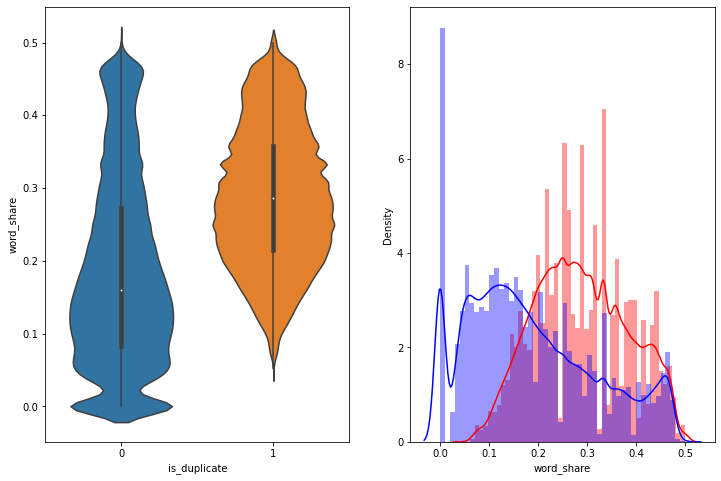

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate",y="word_share",data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1.0]['word_share'][0:],label="1",color='red')
sns.distplot(df[df["is_duplicate"]==0.0]['word_share'][0:],label="0",color="blue")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


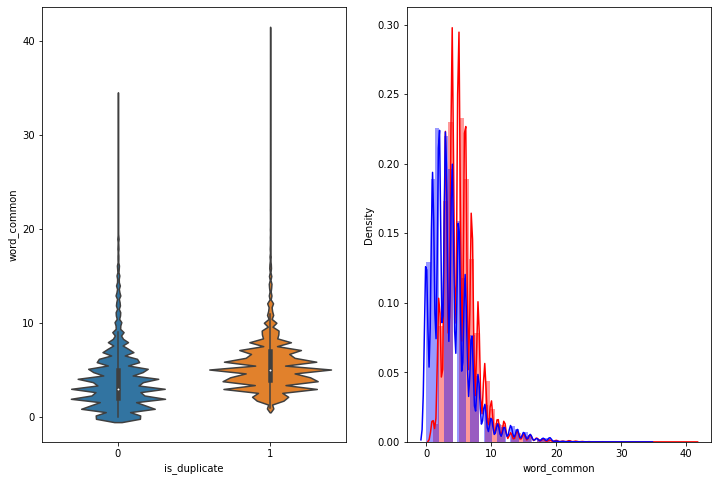

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate",y="word_common",data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1.0]['word_common'][0:],label="1",color='red')
sns.distplot(df[df["is_duplicate"]==0.0]['word_common'][0:],label="0",color="blue")
plt.show()

In [24]:
df.shape

(404290, 20)

In [25]:
nan=df[df.isnull().any(1)]
print(len(nan))

0


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [26]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/somyabansal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
STOP_WORDS=stopwords.words("english")
print(STOP_WORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
SAFE_DIV=0.0001

In [29]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x



<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [30]:
def get_token_features(q1,q2):
    token_features=[0.0]*10
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    q1_words=set([words for words in q1_tokens if words not in STOP_WORDS])
    q2_words=set([words for words in q2_tokens if words not in STOP_WORDS])
    
    q1_stops=set([words for words in q1_tokens if words in STOP_WORDS])
    q2_stops=set([words for words in q2_tokens if words in STOP_WORDS])
    
    common_word_count=len(q1_words.intersection(q2_words))
    
    common_stop_count=len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [31]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("QuoraQuestionPairs_train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [32]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [33]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
#stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
#print(stopwords)
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


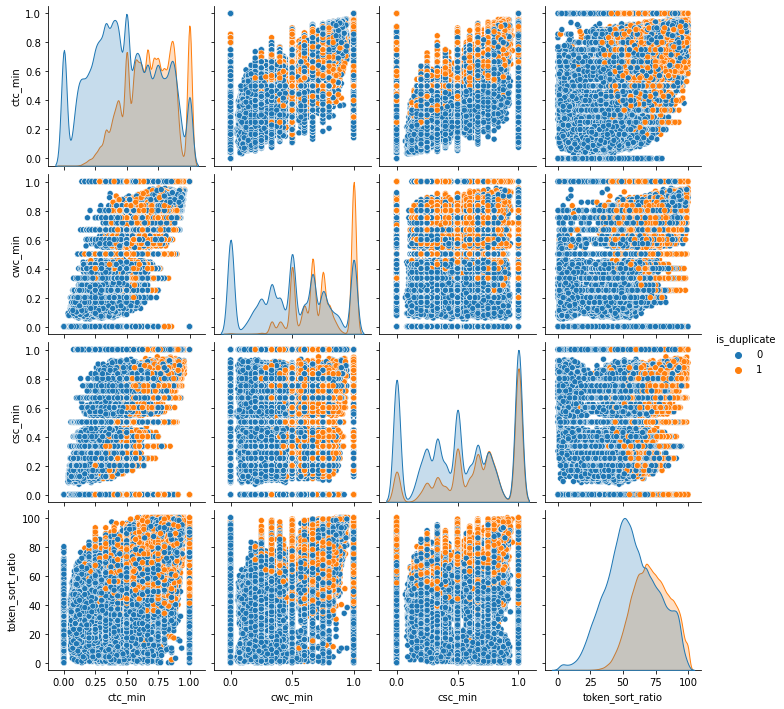

In [34]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


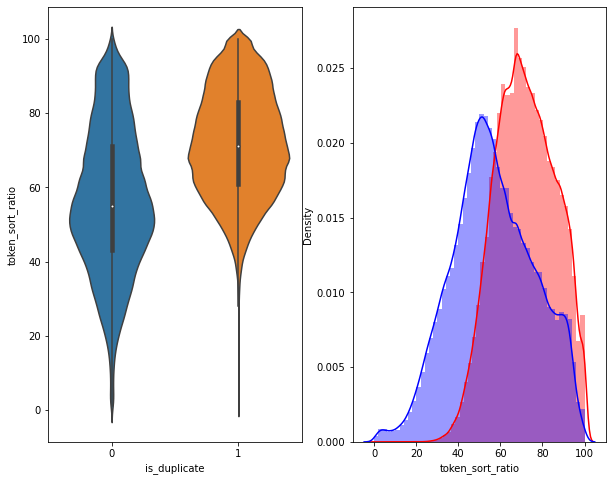

In [35]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


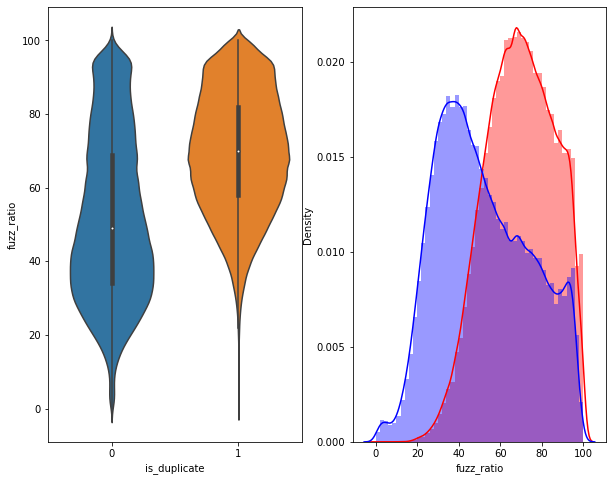

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4>VISUALIZATION</h4>

In [37]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [38]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 404290 samples in 133.440s...
[t-SNE] Computed neighbors for 404290 samples in 457.544s...
[t-SNE] Computed conditional probabilities for sample 1000 / 404290
[t-SNE] Computed conditional probabilities for sample 2000 / 404290
[t-SNE] Computed conditional probabilities for sample 3000 / 404290
[t-SNE] Computed conditional probabilities for sample 4000 / 404290
[t-SNE] Computed conditional probabilities for sample 5000 / 404290
[t-SNE] Computed conditional probabilities for sample 6000 / 404290
[t-SNE] Computed conditional probabilities for sample 7000 / 404290
[t-SNE] Computed conditional probabilities for sample 8000 / 404290
[t-SNE] Computed conditional probabilities for sample 9000 / 404290
[t-SNE] Computed conditional probabilities for sample 10000 / 404290
[t-SNE] Computed conditional probabilities for sample 11000 / 404290
[t-SNE] Computed conditional probabilities for sample 12000 / 404290
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 121000 / 404290
[t-SNE] Computed conditional probabilities for sample 122000 / 404290
[t-SNE] Computed conditional probabilities for sample 123000 / 404290
[t-SNE] Computed conditional probabilities for sample 124000 / 404290
[t-SNE] Computed conditional probabilities for sample 125000 / 404290
[t-SNE] Computed conditional probabilities for sample 126000 / 404290
[t-SNE] Computed conditional probabilities for sample 127000 / 404290
[t-SNE] Computed conditional probabilities for sample 128000 / 404290
[t-SNE] Computed conditional probabilities for sample 129000 / 404290
[t-SNE] Computed conditional probabilities for sample 130000 / 404290
[t-SNE] Computed conditional probabilities for sample 131000 / 404290
[t-SNE] Computed conditional probabilities for sample 132000 / 404290
[t-SNE] Computed conditional probabilities for sample 133000 / 404290
[t-SNE] Computed conditional probabilities for sample 134000 / 404290
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 243000 / 404290
[t-SNE] Computed conditional probabilities for sample 244000 / 404290
[t-SNE] Computed conditional probabilities for sample 245000 / 404290
[t-SNE] Computed conditional probabilities for sample 246000 / 404290
[t-SNE] Computed conditional probabilities for sample 247000 / 404290
[t-SNE] Computed conditional probabilities for sample 248000 / 404290
[t-SNE] Computed conditional probabilities for sample 249000 / 404290
[t-SNE] Computed conditional probabilities for sample 250000 / 404290
[t-SNE] Computed conditional probabilities for sample 251000 / 404290
[t-SNE] Computed conditional probabilities for sample 252000 / 404290
[t-SNE] Computed conditional probabilities for sample 253000 / 404290
[t-SNE] Computed conditional probabilities for sample 254000 / 404290
[t-SNE] Computed conditional probabilities for sample 255000 / 404290
[t-SNE] Computed conditional probabilities for sample 256000 / 404290
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 367000 / 404290
[t-SNE] Computed conditional probabilities for sample 368000 / 404290
[t-SNE] Computed conditional probabilities for sample 369000 / 404290
[t-SNE] Computed conditional probabilities for sample 370000 / 404290
[t-SNE] Computed conditional probabilities for sample 371000 / 404290
[t-SNE] Computed conditional probabilities for sample 372000 / 404290
[t-SNE] Computed conditional probabilities for sample 373000 / 404290
[t-SNE] Computed conditional probabilities for sample 374000 / 404290
[t-SNE] Computed conditional probabilities for sample 375000 / 404290
[t-SNE] Computed conditional probabilities for sample 376000 / 404290
[t-SNE] Computed conditional probabilities for sample 377000 / 404290
[t-SNE] Computed conditional probabilities for sample 378000 / 404290
[t-SNE] Computed conditional probabilities for sample 379000 / 404290
[t-SNE] Computed conditional probabilities for sample 380000 / 404290
[t-SNE] Computed con

/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


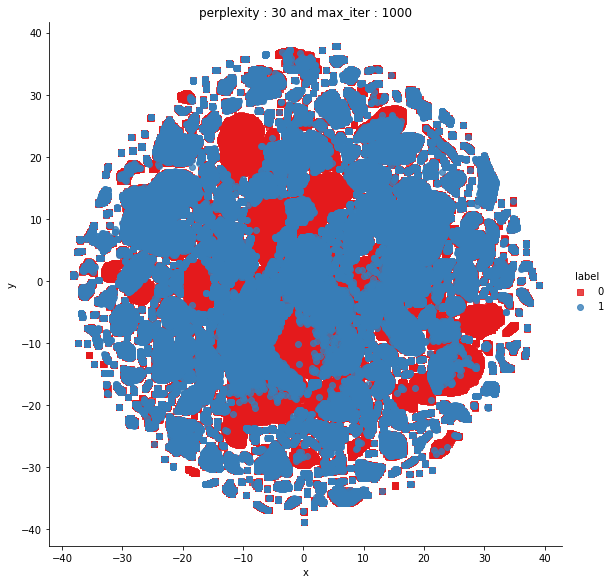

In [39]:

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [41]:
df = pd.read_csv("QuoraQuestionPairs_train.csv")

In [42]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [44]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.1 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [45]:
!python -m spacy download en


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.2 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [55]:
nlp = spacy.load('en_core_web_lg')
vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
     # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
         # word2vec
         vec1 = word1.vector
         # fetch df score
         try:
             idf = word2tfidf[str(word1)]
         except:
             idf = 0
         # compute final vec
         mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████████████████████████████| 404290/404290 [39:05<00:00, 172.39it/s]


In [47]:
x=nlp('man')
len(x.vector)

300

In [58]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████| 404290/404290 [35:20<00:00, 190.66it/s]


In [61]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
if os.path.isfile('QuoraQuestionPairs_trainPart1.csv'):
    dfppro = pd.read_csv("QuoraQuestionPairs_trainPart1.csv",encoding='latin-1')

In [62]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [63]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [64]:
df2.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,2,2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,3,3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,4,4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [65]:
df2=df2.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)

In [66]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [67]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-5.856872,17.449559,4.862720,7.971019,20.345586,-5.514759,-4.077800,-2.820742,8.029026,146.599092,...,-17.370964,5.393082,0.384676,-8.362788,-1.880290,-10.799672,-12.999799,3.225858,1.256145,16.807275
1,9.356103,13.098566,18.945098,-2.079594,-15.703841,-2.173409,8.969065,-20.458267,-20.674299,13.760798,...,25.948247,0.603713,-10.516349,6.040723,30.476707,3.976890,-28.254610,12.613432,-7.770673,31.456654
2,0.909520,16.050299,-8.126856,-4.848289,-2.806190,9.752280,4.349992,-5.120332,6.785252,106.342974,...,-20.942061,2.398984,8.663028,-0.654124,16.220601,-2.719094,10.485332,-1.103132,-7.290877,19.314250
3,-4.950745,17.098874,-15.474965,1.044680,-2.392017,-0.051889,2.650595,-8.451192,2.584123,116.184408,...,-2.551312,-4.971480,-0.478381,-1.930166,9.336016,2.574459,4.803863,-1.182989,-2.962115,3.225704
4,-11.520302,19.769948,-4.510997,-6.548994,-20.835286,33.663909,-30.390504,0.826553,-19.571472,84.458577,...,-8.331733,-4.866335,18.828458,-40.357679,-10.336167,15.294630,-0.989347,-9.072091,-8.194567,23.847560


In [68]:
df3_q2.head()


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.398579,13.991607,-0.504564,9.254431,13.906436,-4.777694,-5.274421,-0.201208,4.940558,134.735950,...,-17.810438,7.231024,1.531186,-7.528823,0.473802,-11.864658,-11.293788,1.866265,3.616046,11.971096
1,4.649688,9.974928,20.330103,-0.440372,-18.128566,-1.984671,4.906458,-27.797837,-21.262646,96.965297,...,23.015827,3.435464,-5.169600,7.102491,34.516881,6.177686,-27.770856,12.926435,-4.564559,33.919834
2,-17.305105,17.355614,-9.135664,-6.038550,-1.831651,4.547895,17.935764,-4.799029,3.100311,99.380095,...,-24.310109,-1.216773,11.909693,9.591573,11.846737,1.397859,6.454157,-0.271460,-12.500337,27.634567
3,3.897911,2.545857,-2.053792,3.385450,3.424216,-2.282545,-11.763825,6.692485,5.797674,94.978085,...,-5.435584,1.672591,-0.863278,-2.906553,-3.466688,-3.867892,-4.249463,-12.551012,4.494087,-6.223341
4,-5.391206,1.767221,1.810128,-4.097073,-3.623262,8.417368,-25.246265,7.473430,-2.789541,89.594627,...,-10.407441,-8.444207,-14.450059,-12.709382,-4.449050,12.563987,-11.721362,-16.459300,3.626297,-9.790615


In [69]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 300
Number of features in question2 w2v  dataframe : 300
Number of features in final dataframe  : 629


In [70]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [72]:
demo=pd.read_csv('final_features.csv')

In [73]:
demo.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-17.810438,7.231024,1.531186,-7.528823,0.473802,-11.864658,-11.293788,1.866265,3.616046,11.971096
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,23.015827,3.435464,-5.169600,7.102491,34.516881,6.177686,-27.770856,12.926435,-4.564559,33.919834
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,-24.310109,-1.216773,11.909693,9.591573,11.846737,1.397859,6.454157,-0.271460,-12.500337,27.634567
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-5.435584,1.672591,-0.863278,-2.906553,-3.466688,-3.867892,-4.249463,-12.551012,4.494087,-6.223341
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,-10.407441,-8.444207,-14.450059,-12.709382,-4.449050,12.563987,-11.721362,-16.459300,3.626297,-9.790615
